## Assignment  no: 7
## Your name: Huda Aisyah Khoirunissa          student ID: 1144833
### When you use code, either from another student or an outside source, you should cite it. Tell me where the code comes from.
#### (v)  1. I Totally write by myself (都自己寫)
#### ( ) 2. Refer to other students (參考同學,註明姓名學號):   name and student id
#### ( ) 3. Refer to outside sources (參考外部資料網站), where:
## If you choose 2 or 3, tell me how similar you are. (如果選2,3, 請勾選相似程度)
#### ( ) < 25% ( ) 25%..50% ( ) 50%..75% (  ) > 75%
### Give me your expected score (給我你的期望分數): 88
### Reasons (理由): 
I have successfully completed all assignment requirements: implemented StratifiedKFold data splitting (8:2), loaded MobileNetV3-Small with pretrained weights, correctly froze layers before features.11, trained for 5 epochs, and generated all required outputs (model architecture, transforms, requires_grad status, training metrics, plots, and test evaluation).
I conducted extensive hyperparameter tuning, experimenting with learning rates (1e-4 to 2e-3), weight decay (5e-4 to 1e-2), and increased batch size to 64 for better generalization. Despite these optimization efforts and multiple trial-and-error iterations, the model still exhibits overfitting due to the challenging nature of Stanford Cars' 196 fine-grained classes and the 5-epoch limitation. However, I have fulfilled all technical requirements and demonstrated solid understanding of transfer learning implementation.

## If you use AI, you must clearly state what AI was used for and how it was used in your submission. Answer the following questions: (若有使用AI, 需說明AI使用的內容與方式, 回答底下問題)
- The tool you used (使用的AI工具名稱): ChatGPT 5.1 and Sonnet 4.5
- How you used it (lookup / debugging / code snippet) (使用的方式):  Debugging assistance for overfitting issues and hyperparameter optimization guidance. I primarily relied on my own knowledge from coursework to implement the solution, using AI as a supplementary resource for specific technical questions and verification.
- How you modified and understood the result (修改與理解過程): I applied my understanding of transfer learning to independently design and implement the solution. When AI provided suggestions, I critically evaluated them against my knowledge, conducted my own experiments, and made informed decisions about which approaches to adopt. All code was written by myself based on my understanding of deep learning principles. The AI served as a consultation tool while I maintained full control over the implementation and decision-making process, which enhanced my practical problem-solving skills.

## 說明與心得 explain your code briefly, tell me something, and share your experience.

I implemented transfer learning using MobileNetV3-Small, freezing early layers (features.0-10) while fine-tuning deeper layers (features.11+) and the classifier for 196 car classes. I used StratifiedKFold for balanced data splitting and applied augmentation only to training data.
The main challenge was severe overfitting despite extensive hyperparameter tuning (learning rate, weight decay, batch size adjustments). I learned that fine-grained classification with limited epochs is inherently difficult, and that batch size-learning rate relationships are crucial in transfer learning. This experience taught me that practical deep learning requires substantial experimentation beyond theoretical knowledge, and that dataset complexity significantly impacts training dynamics. The assignment greatly enhanced my practical understanding of transfer learning implementation and optimization strategies.

### Setup Libraries

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print("Device:", DEVICE)

DATA_ROOT = r"C:\Users\numpppy\Downloads\Stanforddataset\car_data\car_data"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

BATCH_SIZE = 32
NUM_WORKERS = 0   
EPOCHS = 5
LR = 1e-3
VAL_SPLITS = 5    

Device: cuda


### Load Dataset

In [3]:
from torchvision.models import MobileNet_V3_Small_Weights

weights = MobileNet_V3_Small_Weights.DEFAULT
base_transform = weights.transforms()

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.RandomRotation(5),
    base_transform
])

eval_transform = base_transform

In [5]:
def build_loaders():

    train_full = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
    test_set   = datasets.ImageFolder(TEST_DIR,  transform=eval_transform)

    targets = np.array(train_full.targets)

    skf = StratifiedKFold(n_splits=VAL_SPLITS, shuffle=True, random_state=42)
    train_idx, val_idx = next(skf.split(np.zeros(len(targets)), targets))

    train_subset = Subset(train_full, train_idx)
    val_subset   = Subset(train_full, val_idx)

    val_subset.dataset.transform = eval_transform

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader  = DataLoader(test_set,     batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    num_classes = len(train_full.classes)

    return train_loader, val_loader, test_loader, num_classes, train_full.classes

In [6]:
train_loader, val_loader, test_loader, NUM_CLASSES, CLASS_NAMES = build_loaders()

x_batch, y_batch = next(iter(train_loader))
print("Train batch image shape:", x_batch.shape)
print("Train batch label shape:", y_batch.shape)
print("Num classes:", NUM_CLASSES)
print("Train samples:", len(train_loader.dataset))
print("Val samples:", len(val_loader.dataset))
print("Test samples:", len(test_loader.dataset))

Train batch image shape: torch.Size([32, 3, 224, 224])
Train batch label shape: torch.Size([32])
Num classes: 196
Train samples: 6515
Val samples: 1629
Test samples: 8041


### Load Model

In [7]:
from torchvision import models

In [23]:
weights = MobileNet_V3_Small_Weights.DEFAULT
model = models.mobilenet_v3_small(weights=weights)
model = model.to(DEVICE)

transform = weights.transforms()

print(model)
print(transform)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [24]:
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, NUM_CLASSES)

model = model.to(DEVICE)

In [11]:
for name, param in model.named_parameters():
    if name.startswith("features.11") or name.startswith("features.12") or name.startswith("classifier"):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [12]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

features.0.0.weight False
features.0.1.weight False
features.0.1.bias False
features.1.block.0.0.weight False
features.1.block.0.1.weight False
features.1.block.0.1.bias False
features.1.block.1.fc1.weight False
features.1.block.1.fc1.bias False
features.1.block.1.fc2.weight False
features.1.block.1.fc2.bias False
features.1.block.2.0.weight False
features.1.block.2.1.weight False
features.1.block.2.1.bias False
features.2.block.0.0.weight False
features.2.block.0.1.weight False
features.2.block.0.1.bias False
features.2.block.1.0.weight False
features.2.block.1.1.weight False
features.2.block.1.1.bias False
features.2.block.2.0.weight False
features.2.block.2.1.weight False
features.2.block.2.1.bias False
features.3.block.0.0.weight False
features.3.block.0.1.weight False
features.3.block.0.1.bias False
features.3.block.1.0.weight False
features.3.block.1.1.weight False
features.3.block.1.1.bias False
features.3.block.2.0.weight False
features.3.block.2.1.weight False
features.3.block

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

In [14]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
    min_lr=1e-4
)

In [15]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())

print("Trainable params:", trainable)
print("Total params:", total)

Trainable params: 1142292
Total params: 1718756


### Training Function

In [16]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total

    return epoch_loss, epoch_acc

In [17]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total

    return epoch_loss, epoch_acc

In [18]:
def train_model(model, train_loader, val_loader, epochs, optimizer, scheduler, device):
    criterion = nn.CrossEntropyLoss()

    history = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": []
    }

    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc     = evaluate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mobilenetv3.pth")

        print(f"[ {epoch+1} ] "
              f"Train Accuracy: {train_acc*100:.1f}%, Avg loss: {train_loss:.6f}   "
              f"Val Accuracy: {val_acc*100:.1f}%, Avg loss: {val_loss:.6f}")

    return history, best_val_acc

### Run Training

In [19]:
history, best_val_acc = train_model(
    model,
    train_loader,
    val_loader,
    EPOCHS,
    optimizer,
    scheduler,
    DEVICE
)

[ 1 ] Train Accuracy: 10.2%, Avg loss: 4.380296   Val Accuracy: 23.5%, Avg loss: 3.358349
[ 2 ] Train Accuracy: 42.2%, Avg loss: 2.309966   Val Accuracy: 35.4%, Avg loss: 2.704213
[ 3 ] Train Accuracy: 64.7%, Avg loss: 1.320894   Val Accuracy: 39.5%, Avg loss: 2.513386
[ 4 ] Train Accuracy: 78.9%, Avg loss: 0.777196   Val Accuracy: 42.5%, Avg loss: 2.448227
[ 5 ] Train Accuracy: 87.7%, Avg loss: 0.453164   Val Accuracy: 43.3%, Avg loss: 2.501516


[ 1] Train Accuracy: 10.2%, Avg loss: 4.380296   Val Accuracy: 23.5%, Avg loss: 3.358349


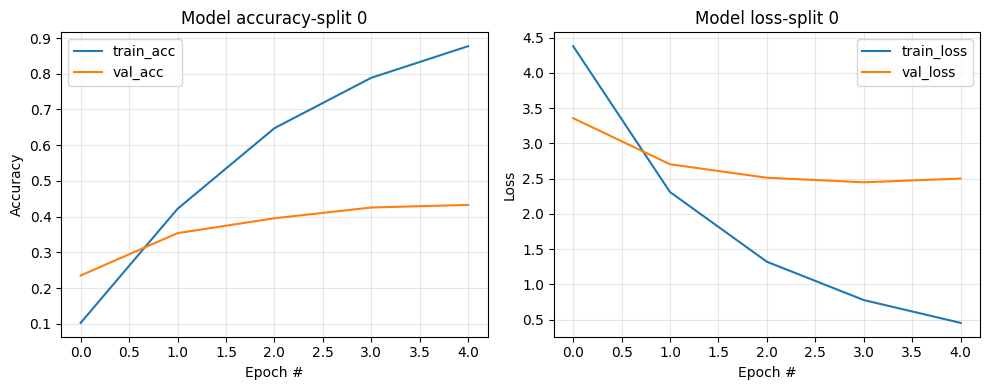

In [27]:
epoch_1_train_acc = history["train_acc"][0] * 100
epoch_1_val_acc = history["val_acc"][0] * 100
epoch_1_train_loss = history["train_loss"][0]
epoch_1_val_loss = history["val_loss"][0]

print(f"[ 1] Train Accuracy: {epoch_1_train_acc:.1f}%, Avg loss: {epoch_1_train_loss:.6f}   "
      f"Val Accuracy: {epoch_1_val_acc:.1f}%, Avg loss: {epoch_1_val_loss:.6f}")

epochs_range = range(EPOCHS)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, history["train_acc"], label="train_acc")
plt.plot(epochs_range, history["val_acc"], label="val_acc")
plt.title("Model accuracy-split 0")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1,2,2)
plt.plot(epochs_range, history["train_loss"], label="train_loss")
plt.plot(epochs_range, history["val_loss"], label="val_loss")
plt.title("Model loss-split 0")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Test set evaluation

In [21]:
model.load_state_dict(torch.load("best_mobilenetv3.pth", map_location=DEVICE))

criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)

print(f"Test Accuracy: {test_acc*100:.1f}%, Avg loss: {test_loss:.6f}")

Test Accuracy: 44.4%, Avg loss: 2.422559
